In [50]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.table import Table

In [51]:
extended_exposure_table = Table.read('extended_exposure_data.ecsv').to_pandas()
no_wind_speed = extended_exposure_table['WIND_SPEED_AVG']<1E-5
ii = ~(no_wind_speed)
data = extended_exposure_table[ii]
gfa = Table.read("/global/cfs/cdirs/desi/survey/GFA/offline_matched_coadd_ccds_main-thru_20241126.fits", hdu=2).to_pandas()

In [55]:
def merge_gfa_exposures(gfa_df, exp_df, columns_to_add):
    """
    Merge GFA and exposure dataframes based on EXPID using pandas merge
    """
    # Make a copy of the exposure DataFrame
    exp_df = exp_df.copy()
    
    # Select only the columns we need from gfa_df
    gfa_subset = gfa_df[['EXPID'] + columns_to_add]
    
    # Merge the dataframes on EXPID
    merged_df = pd.merge(exp_df, gfa_subset, on='EXPID', how='left')
    
    #drop nans
    merged_df = merged_df.dropna()
    return merged_df

# Define columns to add
columns_to_add = [
    'MOON_ILLUMINATION', 'MOON_ZD_DEG', 'MOON_SEP_DEG',
    'FRACFLUX_NOMINAL_POINTSOURCE', 'FRACFLUX_NOMINAL_ELG',
    'FRACFLUX_NOMINAL_BGS', 'FWHM_ASEC', 'TRANSPARENCY',
    'SKY_MAG_AB', 'FIBER_FRACFLUX', 'FIBER_FRACFLUX_ELG',
    'FIBER_FRACFLUX_BGS', 'AIRMASS', 'FIBERFAC',
    'FIBERFAC_ELG', 'FIBERFAC_BGS'
]

# Merge the dataframes
data_extended = merge_gfa_exposures(gfa, data, columns_to_add)

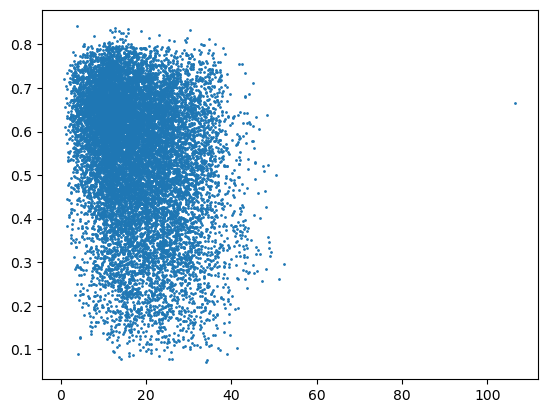

In [56]:
plt.scatter(data_extended['WIND_SPEED_AVG'], data_extended['FIBER_FRACFLUX'], s =1.0)

In [57]:
data_extended['FIBERFAC']

0        0.597997
1        0.743907
2        0.675905
3        0.474429
4        0.819243
           ...   
15184    1.142093
15185    1.060085
15186    1.159225
15187    1.116921
15188    1.159505
Name: FIBERFAC, Length: 14821, dtype: float64

In [58]:
np.count_nonzero(np.isnan(gfa['FIBERFAC']))

113

In [59]:
np.count_nonzero(np.isnan(data_extended['FIBERFAC'])), len(data_extended)

(0, 14821)

In [87]:
# Create a copy of the data first to avoid chained indexing
data = data_extended.copy()

# Clean data by dropping NaN values first
data = data_extended.dropna()

# Create new columns using .loc
data.loc[:, 'WIND_EVENT'] = data['WIND_SHAKE_SUM'] + data['WIND_GUST_SUM']
data.loc[:, 'RANDOM_VAR'] = np.random.random(len(data))
#data.loc[:, 'WIND_EVENT_BINARY'] = (data['WIND_EVENT'] > 0).astype(int)

# Select features (excluding WIND_EVENT, WIND_SHAKE_SUM, WIND_GUST_SUM, and target)
feature_cols = ['WIND_SPEED_AVG', 'WIND_OPENING_ANGLE', 'WIND_SHAKE_SUM', 'WIND_GUST_SUM', 'MOON_ILLUMINATION', 'MOON_ZD_DEG', 'MOON_SEP_DEG',
               'RANDOM_VAR', 'SKY_MAG_AB', 'AIRMASS']

target_feature = 'FWHM_ASEC'
# Create feature matrix and target vector
X = data[feature_cols]
y = data[target_feature]

# Print information about the dataset
print(f"Dataset size: {len(X)}")

Dataset size: 14821


In [88]:
data.keys()

Index(['EXPID', 'MJD', 'TIMESTAMP', 'EXPTIME', 'SURVEY', 'PROGRAM', 'MOUNT_EL',
       'MOUNT_AZ', 'WIND_GUST_SUM', 'WIND_SHAKE_SUM', 'WIND_SPEED_AVG',
       'WIND_SPEED_STD', 'WIND_DIRECTION_AVG', 'WIND_DIRECTION_STD',
       'GUST_AVG', 'GUST_STD', 'WIND_OPENING_ANGLE', 'MOON_ILLUMINATION',
       'MOON_ZD_DEG', 'MOON_SEP_DEG', 'FRACFLUX_NOMINAL_POINTSOURCE',
       'FRACFLUX_NOMINAL_ELG', 'FRACFLUX_NOMINAL_BGS', 'FWHM_ASEC',
       'TRANSPARENCY', 'SKY_MAG_AB', 'FIBER_FRACFLUX', 'FIBER_FRACFLUX_ELG',
       'FIBER_FRACFLUX_BGS', 'AIRMASS', 'FIBERFAC', 'FIBERFAC_ELG',
       'FIBERFAC_BGS', 'WIND_EVENT', 'RANDOM_VAR'],
      dtype='object')


Feature Importance Rankings (Regression):
WIND_SPEED_AVG: 0.1788
AIRMASS: 0.1763
MOON_ILLUMINATION: 0.1729
WIND_OPENING_ANGLE: 0.1112
SKY_MAG_AB: 0.0883
MOON_ZD_DEG: 0.0771
MOON_SEP_DEG: 0.0705
RANDOM_VAR: 0.0524
WIND_SHAKE_SUM: 0.0398
WIND_GUST_SUM: 0.0327

Model Performance:
Mean Squared Error: 0.1208
R² Score: 0.2781
Root Mean Squared Error: 0.3476


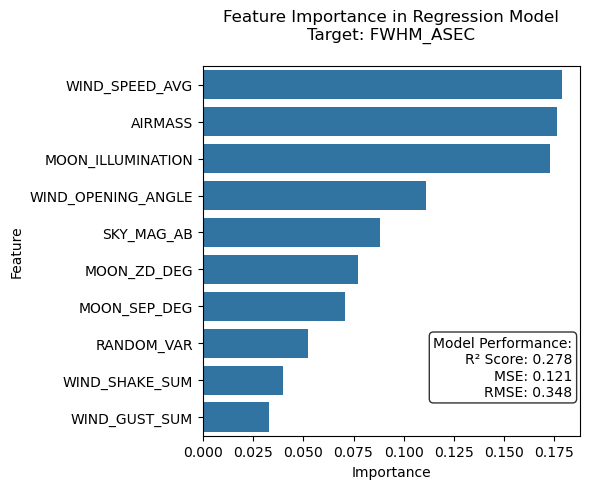

In [89]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=40, random_state=42, max_depth=10)
rf.fit(X_train, y_train)

# Get feature importance
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Calculate performance metrics
y_pred = rf.predict(X_test)
mse = np.mean((y_test - y_pred) ** 2)
r2 = rf.score(X_test, y_test)
rmse = np.sqrt(mse)

# Create the plot
fig, ax = plt.subplots(figsize=(6, 5))

# Plot the feature importance barplot
sns.barplot(data=importance_df, x='Importance', y='Feature', ax=ax)

# Add title with target feature
plt.title(f'Feature Importance in Regression Model\nTarget: {target_feature}', pad=20)
plt.xlabel('Importance')
plt.ylabel('Feature')

# Add performance metrics text box
metrics_text = f'Model Performance:\nR² Score: {r2:.3f}\nMSE: {mse:.3f}\nRMSE: {rmse:.3f}'
plt.text(0.98, 0.10, metrics_text,
         transform=ax.transAxes,
         verticalalignment='bottom',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('feature_importance_regression_{}.jpg'.format(target_feature), bbox_inches='tight', dpi=300)

# Print the feature importance values
print("\nFeature Importance Rankings (Regression):")
for idx, row in importance_df.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

print(f"\nModel Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")